# Jane Street Market Prediction 
> Buy low, sell high. It sounds so easy….

- toc: true
- badges: true
- author: Austin Chen
- categories: [time series,stock,kaggle]

# 1% Better Everyday

- I see that autoencoders are widely being used in this competition. However, I am having some doubts on wether the autoencoded features really help the model. As shown in the notebook, the compressed features concatenated back into the original data as extra featues. For me personally, I've tried 2~3 different random seed and the variation on the results are large. It makes me wonder that the autoencoder is only useful on certain features, so dropping these from the autoencoder might be a good idea.

- Maybe we can feed the autoencoded features to non-nn models e.g. Xgboost, CatBoost, CBM? [refence](https://www.kaggle.com/gregorycalvez/de-anonymization-time-aggregation-tags)

- Maybe we need to remove correlated featues before generating autoencoded features.


# Overview

The efficient market hypothesis posits that markets cannot be beaten because asset prices will always reflect the fundamental value of the assets. In a perfectly efficient market, buyers and sellers would have all the agency and information needed to make rational trading decisions.

In reality, financial markets are not efficient. The purpose of this trading model is to identify arbitrage opportunities to "buy low and seell high". In other words, we exploit market inefficiencies to identify and decide whether to execute profitable trades.

The dataset, provided by Jane Street, contains an anonymized set of 129 features representing real stock market data. Each row in the dataset represents a trading opportunity, for which I predict an action value: 1 to amke the trade and 0 to pass on it. Due to the high demensionality of the dataset, I use Principal Components Analysis (PCA) to identify features to be used for supervised learning. The intuition is to compress the dataset and use it more efficiently. I then use XGBoost (extreme gradient boosting) - a hugely popular ML library due to its superior execution speed and model performance - to predict profitable trades. I also use Optuna (an automatic hyperparameter optimization software framework) to tune the hyperparameters of the classification model.

# Prework

In [ ]:
#hide

%%writefile conditional_cell_extension.py
def run_if(line, cell=None):
    '''Execute current line/cell if line evaluates to True.'''
    if not eval(line):
        return
    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the run_if magic when the extension loads.'''
    shell.register_magic_function(run_if, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the run_if magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['run_if']

Overwriting conditional_cell_extension.py


In [ ]:
#hide
%reload_ext conditional_cell_extension

In [ ]:
#hide
!pip install dabl > /dev/null
!pip install datatable > /dev/null
!pip install keras-tuner > /dev/null

In [ ]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import os, gc, cv2, random, warnings
import re, math, sys, json, pprint, pdb

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

import dabl
import datatable as dt
import kerastuner as kt

import altair as alt

warnings.simplefilter('ignore')
print(f"Using TensorFlow v{tf.__version__}")

Using TensorFlow v2.4.0


In [ ]:
#hide
#@title Accelerator { run: "auto" }
DEVICE = 'GPU' #@param ["None", "'GPU'", "'TPU'"] {type:"raw", allow-input: true}

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTOTUNE = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  0
REPLICAS: 1


In [ ]:
#hide
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
                name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#collapse-hide
#@title Notebook type { run: "auto", display-mode:"form" }
SEED = 10120919
DEBUG = False #@param {type:"boolean"}
TRAIN = True #@param {type:"boolean"}

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

GOOGLE = 'google.colab' in str(get_ipython())
KAGGLE = not GOOGLE

seed_everything(SEED)

print("Running on {}!".format(
   "Google Colab" if GOOGLE else "Kaggle Kernel"
))

Running on Google Colab!


In [ ]:
#hide
%%run_if {GOOGLE}
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#hide
project_name = 'jane-street-market-prediction'
root_path  = '/content/gdrive/MyDrive/' if GOOGLE else '/'
input_path = f'{root_path}kaggle/input/{project_name}/'
working_path = f'{input_path}working/' if GOOGLE else '/kaggle/working/'
os.makedirs(working_path, exist_ok=True)
os.chdir(working_path)
os.listdir(input_path)

['train.csv',
 'working',
 '__init__.py',
 'competition.cpython-37m-x86_64-linux-gnu.so',
 'train.csv.zip',
 'example_sample_submission.csv',
 'features.csv',
 'example_test.csv.zip']

In [ ]:
#hide
!kaggle competitions download -c jane-street-market-prediction

# Data

## Loading

- Anonymized set of features, featue_{0..129}, representing real stock market data. 
- Each row in the dataset represents a trading opportunity, for which which you will be predicting an action value: 1 to make the trade and 0 to pass on it.
- In the training set, you are provided a `resp` value, as well as several other `resp_{1,2,3,4}` values that represent returns over different time horizons. These variables are not included in the test set.
- Trades with `weight = 0` were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.

First off, since this is a large file to gulp. I will try to use [`datatable`](https://github.com/h2oai/datatable) to load the data, and then convert to a pandas dataframe.

In [ ]:
%%time
train_dt = dt.fread(f"{input_path}train.csv")

CPU times: user 32.2 s, sys: 6.57 s, total: 38.8 s
Wall time: 3min 15s


In [ ]:
%%time
train_df = train_dt.to_pandas()

CPU times: user 5.96 s, sys: 5.43 s, total: 11.4 s
Wall time: 8.95 s


The dataframe is `2390490` rows by `138` columns

In [ ]:
#hide_input
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int32(3)
memory usage: 2.4 GB


## Exploration

In [ ]:
train_df.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,-1.055090,NaN,NaN,-2.667671,-2.001475,-1.703595,-2.196892,NaN,NaN,1.483295,1.307466,NaN,NaN,1.175200,0.967805,1.608410,1.319365,NaN,NaN,-0.515073,-0.448988,NaN,NaN,...,1.158770,NaN,3.754522,7.137163,-1.863069,NaN,0.434466,NaN,-0.292035,0.317003,-2.605820,NaN,2.896986,NaN,1.485813,4.147254,-2.238831,NaN,-0.892724,NaN,-0.156332,0.622816,-3.921523,NaN,2.561593,NaN,3.457757,6.649580,-1.472686,NaN,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,-0.384952,NaN,NaN,1.225838,0.789076,1.110580,1.102281,NaN,NaN,-0.590600,-0.625682,NaN,NaN,-0.543425,-0.547486,-0.706600,-0.667806,NaN,NaN,0.910558,0.914465,NaN,NaN,...,1.157671,NaN,1.297679,1.281956,-2.427595,NaN,0.024913,NaN,-0.413607,-0.073672,-2.434546,NaN,0.949879,NaN,0.724655,1.622137,-2.209020,NaN,-1.332492,NaN,-0.586619,-1.040491,-3.946097,NaN,0.983440,NaN,1.357907,1.612348,-1.664544,NaN,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,5.448261,2.668029,NaN,NaN,3.836342,2.183258,3.902698,3.045431,NaN,NaN,-1.141082,-0.979962,NaN,NaN,-1.157585,-0.966803,-1.430973,-1.103432,NaN,NaN,5.131559,4.314714,NaN,NaN,...,2.420089,NaN,0.800962,1.143663,-3.214578,NaN,1.585939,NaN,0.193996,0.953114,-2.674838,NaN,2.200085,NaN,0.537175,2.156228,-3.568648,NaN,1.193823,NaN,0.097345,0.796214,-4.090058,NaN,2.548596,NaN,0.882588,1.817895,-2.432424,NaN,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,4.508206,2.484260,NaN,NaN,2.902176,1.799163,3.192700,2.848359,NaN,NaN,-1.401637,-1.428248,NaN,NaN,-1.421175,-1.487976,-1.756415,-1.647543,NaN,NaN,4.766182,4.528353,NaN,NaN,...,2.330484,NaN,0.182066,1.088451,-3.527752,NaN,-1.338859,NaN,-1.257774,-1.194013,-1.719062,NaN,-0.940190,NaN,-1.510224,-1.781693,-3.373969,NaN,2.513074,NaN,0.424964,1.992887,-2.616856,NaN,0.561528,NaN,-0.994041,0.099560,-2.485993,NaN,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,2.683018,1.450991,NaN,NaN,1.257761,0.632336,0.905204,0.575275,NaN,NaN,2.550883,2.484082,NaN,NaN,2.502828,2.606440,2.731251,2.566561,NaN,NaN,-1.477905,-1.722451,NaN,NaN,...,4.345282,NaN,2.737738,2.602937,-1.785502,NaN,-0.172561,NaN,-0.299516,-0.420021,-2.354611,NaN,0.762192,NaN,1.598620,0.623132,-1.742540,NaN,-0.934675,NaN,-0.373013,-1.213540,-3.677787,NaN,2.684119,NaN,2.861848,2.134804,-1.279284,NaN,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4


In [ ]:
train_df.ts_id.unique()

array([      0,       1,       2, ..., 2390488, 2390489, 2390490],
      dtype=int32)

- Intraday trading patterns in hight frequency algorithmic trading are far more linked than interday patterns, so that why I have decided to look at only one data of data for EDA.

- Since not enough information is given about these featues, I am assuming that `ts_id` here represent packet Number of any commodity from any stock exchange that was used while creating this data.

- These packets can be any type usually the main type of packets that we receive of different commidities from stock exchange are about Trade, Delete, update, Reduce Messages/ Packets about changes in limit order book.

In [ ]:
train_df.sort_values(by=['date','ts_id'], inplace=True)

After sorting data by `date`, let's look at only the first day of data

In [ ]:
sample_df = train_df.query('date == 0')
sample_df.describe()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
count,5587.0,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,4787.000000,4787.000000,5585.000000,5585.000000,5401.000000,5401.000000,5553.000000,5553.000000,5571.000000,5571.000000,4784.000000,4784.000000,5585.000000,5585.000000,5399.000000,5399.000000,5553.000000,5553.000000,5571.000000,5571.000000,4784.000000,4784.000000,5585.000000,5585.000000,5399.000000,5399.000000,...,5585.000000,5435.000000,5553.000000,5571.000000,5587.000000,4871.000000,5585.000000,5435.000000,5553.000000,5571.000000,5587.000000,4871.000000,5585.000000,5435.000000,5553.000000,5571.000000,5587.000000,4871.000000,5585.000000,5435.000000,5553.000000,5571.000000,5587.000000,4871.000000,5585.000000,5435.000000,5553.000000,5571.000000,5587.000000,5437.000000,5437.000000,5587.000000,5587.000000,5552.000000,5552.000000,5566.000000,5566.000000,5583.000000,5583.000000,5587.000000
mean,0.0,2.004706,0.000020,0.000036,0.000460,0.002755,0.002285,0.020226,0.704028,-0.595923,0.102204,0.017371,0.111686,0.042895,0.169014,-0.085089,0.855089,-0.367322,0.249186,-0.225808,0.505852,-0.261926,0.637426,-0.470387,0.178181,0.026680,0.414203,0.121306,0.347005,0.098755,0.403261,0.137059,0.420384,0.128853,0.238670,0.113446,0.503686,0.229105,0.331015,0.150020,...,0.804891,0.626870,0.598617,0.658164,0.721280,0.115894,0.311491,0.131886,0.201736,0.234506,0.119657,0.590469,0.703889,0.495732,0.515177,0.633540,0.649164,0.103825,0.115466,0.224546,0.205613,0.084561,0.123119,0.643725,0.853178,0.688223,0.728163,0.792377,0.608926,1.006430,-0.677243,1.021091,-0.448813,0.968835,-0.729380,1.243077,-0.513070,1.130553,-0.436875,2793.000000
std,0.0,5.756178,0.011050,0.014902,0.027288,0.035080,0.028258,0.999885,2.824716,1.820124,2.443553,1.209477,2.060284,1.006739,2.014289,1.230859,2.531002,1.115580,1.828665,1.499428,2.462539,1.222786,2.069017,1.495159,1.565842,1.151467,1.916910,1.201830,2.556400,0.986929,2.317814,1.601241,2.277173,1.393124,1.984193,1.469888,2.021975,1.324900,2.021699,1.691045,...,3.207743,2.022387,2.238293,2.581071,2.098956,1.732061,2.097978,1.910073,1.649681,1.729739,1.644195,2.090357,2.525400,1.577918,1.895602,2.893104,2.107754,2.295506,2.250570,1.746352,1.891005,2.601807,2.075908,1.887119,2.578053,2.094636,2.319472,2.512411,1.671011,2.025139,1.979969,2.308991,1.722394,1.942894,2.181850,2.749516,1.651623,2.529628,1.543382,1612.972308
min,0.0,0.000000,-0.162525,-0.169475,-0.194096,-0.216788,-0.168365,-1.000000,-3.172026,-3.093182,-7.401405,-4.544310,-6.102448,-3.287124,-11.873722,-7.726835,-11.549056,-6.528488,-17.364956,-12.226912,-25.777177,-14.323229,-11.655753,-7.833867,-10.272717,-7.365138,-7.375763,-4.552891,-16.118822,-7.938220,-14.559287,-8.702156,-12.235744,-7.684609,-11.795004,-8.468562,-9.238102,-7.280102,-19.087814,-13.497338,...,-1.515613,-2.115890,-1.746285,-1.086886,-5.333725,-2.627354,-1.338859,-2.175540,-1.257774,-1.194013,-3.194766,-4.660854,-0.940190,-1.652230,-1.510224,-1.781693,-5.022859,-4.463797,-3.548454,-1.990096,-1.838865,-3.807339,-5.018341,-4.149114,-2.922627,-4.291076,-4.159270,-3.202494,-3.32306

In [52]:
sample_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            5577, 5578, 5579, 5580, 5581, 5582, 5583, 5584, 5585, 5586],
           dtype='int64', length=5587)

In [60]:
nan_df.index

Index(['date', 'weight', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp',
       'feature_0', 'feature_1', 'feature_2',
       ...
       'feature_121', 'feature_122', 'feature_123', 'feature_124',
       'feature_125', 'feature_126', 'feature_127', 'feature_128',
       'feature_129', 'ts_id'],
      dtype='object', length=138)

In [63]:
nan_df = (sample_df.describe()
            .iloc[0,:]
            .apply(lambda x : len(sample_df)-x)
            .to_frame()
            .reset_index())

In [65]:
nan_df.columns

Index(['index', 'count'], dtype='object')

In [66]:
chart = alt.Chart(nan_df).mark_bar().encode(
    x = 'count',
    y = 'index',
)

In [67]:
chart

alt.Chart(...)

From the bar chart shown above, there are lots of missing values. I simply replace the `nan` with the mean value because [mean reversion strategy](https://en.wikipedia.org/wiki/Mean_reversion_(finance)) that I think has been used here.

In [ ]:
sample_df = sample_df.apply(lambda x: x.fillna(x.mean()), axis=0)

Here I am plotting the histogram of all the features that are present in this dataset.

In [ ]:
from ipywidgets import interact, widgets

In [ ]:
@interact(x=True, y=1.0)
def g(x, y):
    return (x, y)

interactive(children=(Checkbox(value=True, description='x'), FloatSlider(value=1.0, description='y', max=3.0, …

In [ ]:
@interact(feature_name=sample_df.iloc[:,7:].columns)
def g(feature_name):
    fig, ax = plt.subplots(figsize=(12,8))
    sns.distplot(sample_df[feature_name], ax=ax)

interactive(children=(Dropdown(description='feature_name', options=('feature_0', 'feature_1', 'feature_2', 'fe…

I know it is a tiresome to eyes at the charts shown above, but what takeaways do we have here.
- Most of the features are normally distributed.
- Most of the features are mean/zero reverted.
- `Feature 0` seems that it is a signal, i.e. in HFT, it can be used to track, [volume imbalance](https://www.bluevillecapital.com/post/what-is-volume-imbalance-and-how-to-find-it) in limit order book.

> Note: There are multiple approaches that are being used by traders. The two main approaches are
- [Momentum Based Strategy](https://www.investopedia.com/trading/introduction-to-momentum-trading/)
- [Zero/Mean Reverted Strategy](https://decodingmarkets.com/mean-reversion-trading-strategy/)


### Weight

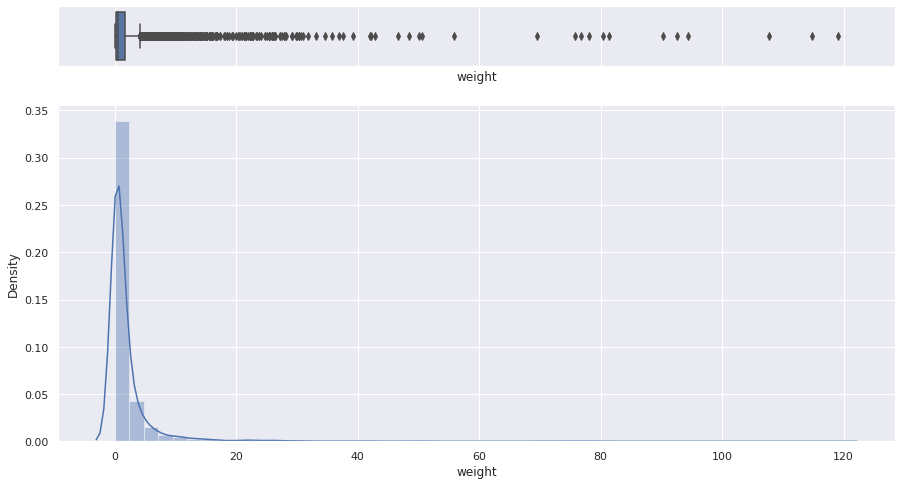

In [ ]:
fig, axs = plt.subplots(2, sharex=True,
                        gridspec_kw={"height_ratios":(.15, .85)})
sns.set(rc={'figure.figsize':(15,8)})
_ = sns.boxplot(sample_df['weight'], ax=axs[0])
_ = sns.distplot(sample_df['weight'], ax=axs[1])

From above chart, we can justify the desciption given by competition host that
> Trades with `weight = 0` were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation

### Resp

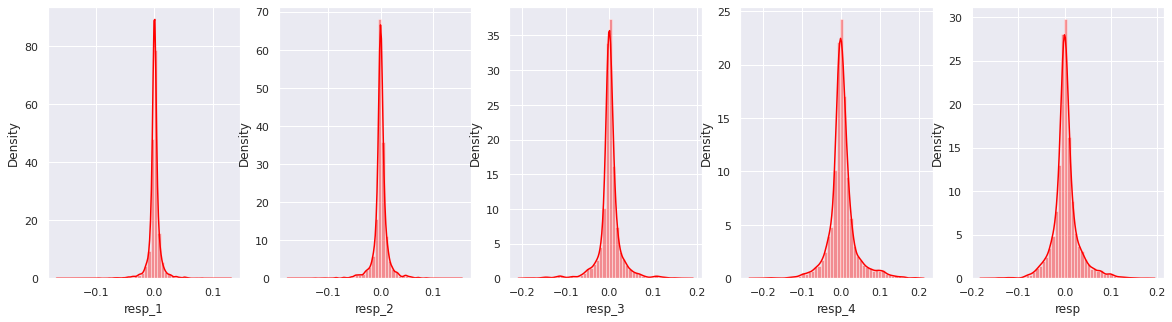

In [ ]:
resp_df = sample_df.iloc[:,2:7]
fig,axs = plt.subplots(1, 5, figsize=(20,5))
for i,(col,ax) in enumerate(zip(resp_df.columns,axs.flatten())):
    sns.distplot(sample_df[col], ax=ax, color='red')

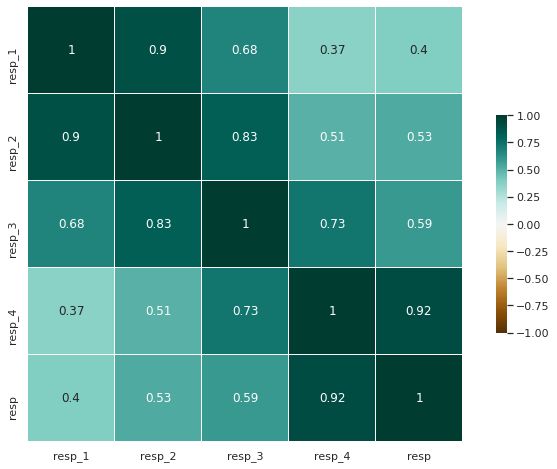

In [ ]:
corr = resp_df.corr()
fig,ax = plt.subplots(figsize=(12,8))
_ = sns.heatmap(corr, cmap='BrBG', center=0, vmin=-1, vmax=1,
            annot=True, square=True, linewidths=.5,
            cbar_kws={'shrink':.5})

From the correlation chart we see that `resp_4` has the highest positive correlation with `resp` while `resp_1` has the least positive correlation with `resp`.

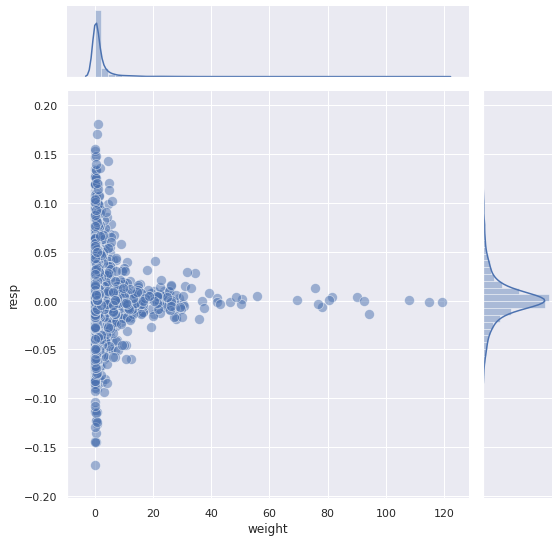

In [ ]:
g = sns.JointGrid(data=sample_df, height=7.7, x="weight", y="resp")
_ = g.plot_joint(sns.scatterplot, s=100, alpha=.5)
_ = g.plot_marginals(sns.distplot, kde=True)

I experimentally divide these trades into three categories, less than 40, between 40 and 80, greater than 80. I will look into these in later section.

In [ ]:
conditions = [
    (sample_df['weight'] <= 40),
    (sample_df['weight'] > 40) & (sample_df['weight'] <= 80),
    (sample_df['weight'] > 80) 
    ]
values = ['tier_3', 'tier_2', 'tier_1']
sample_df['weight_tier'] = np.select(conditions, values)

In [ ]:
from collections import defaultdict
meta_df = pd.read_csv(f"{input_path}features.csv")

In [ ]:
categories =  defaultdict(list)
for columns  in meta_df.columns[1:]:
        (categories[f'{columns}']
            .append(meta_df.query(f'{columns} == True')['feature']
            .to_list()))

In [ ]:
tag_0_df = sample_df[[*categories['tag_0'][0]]]

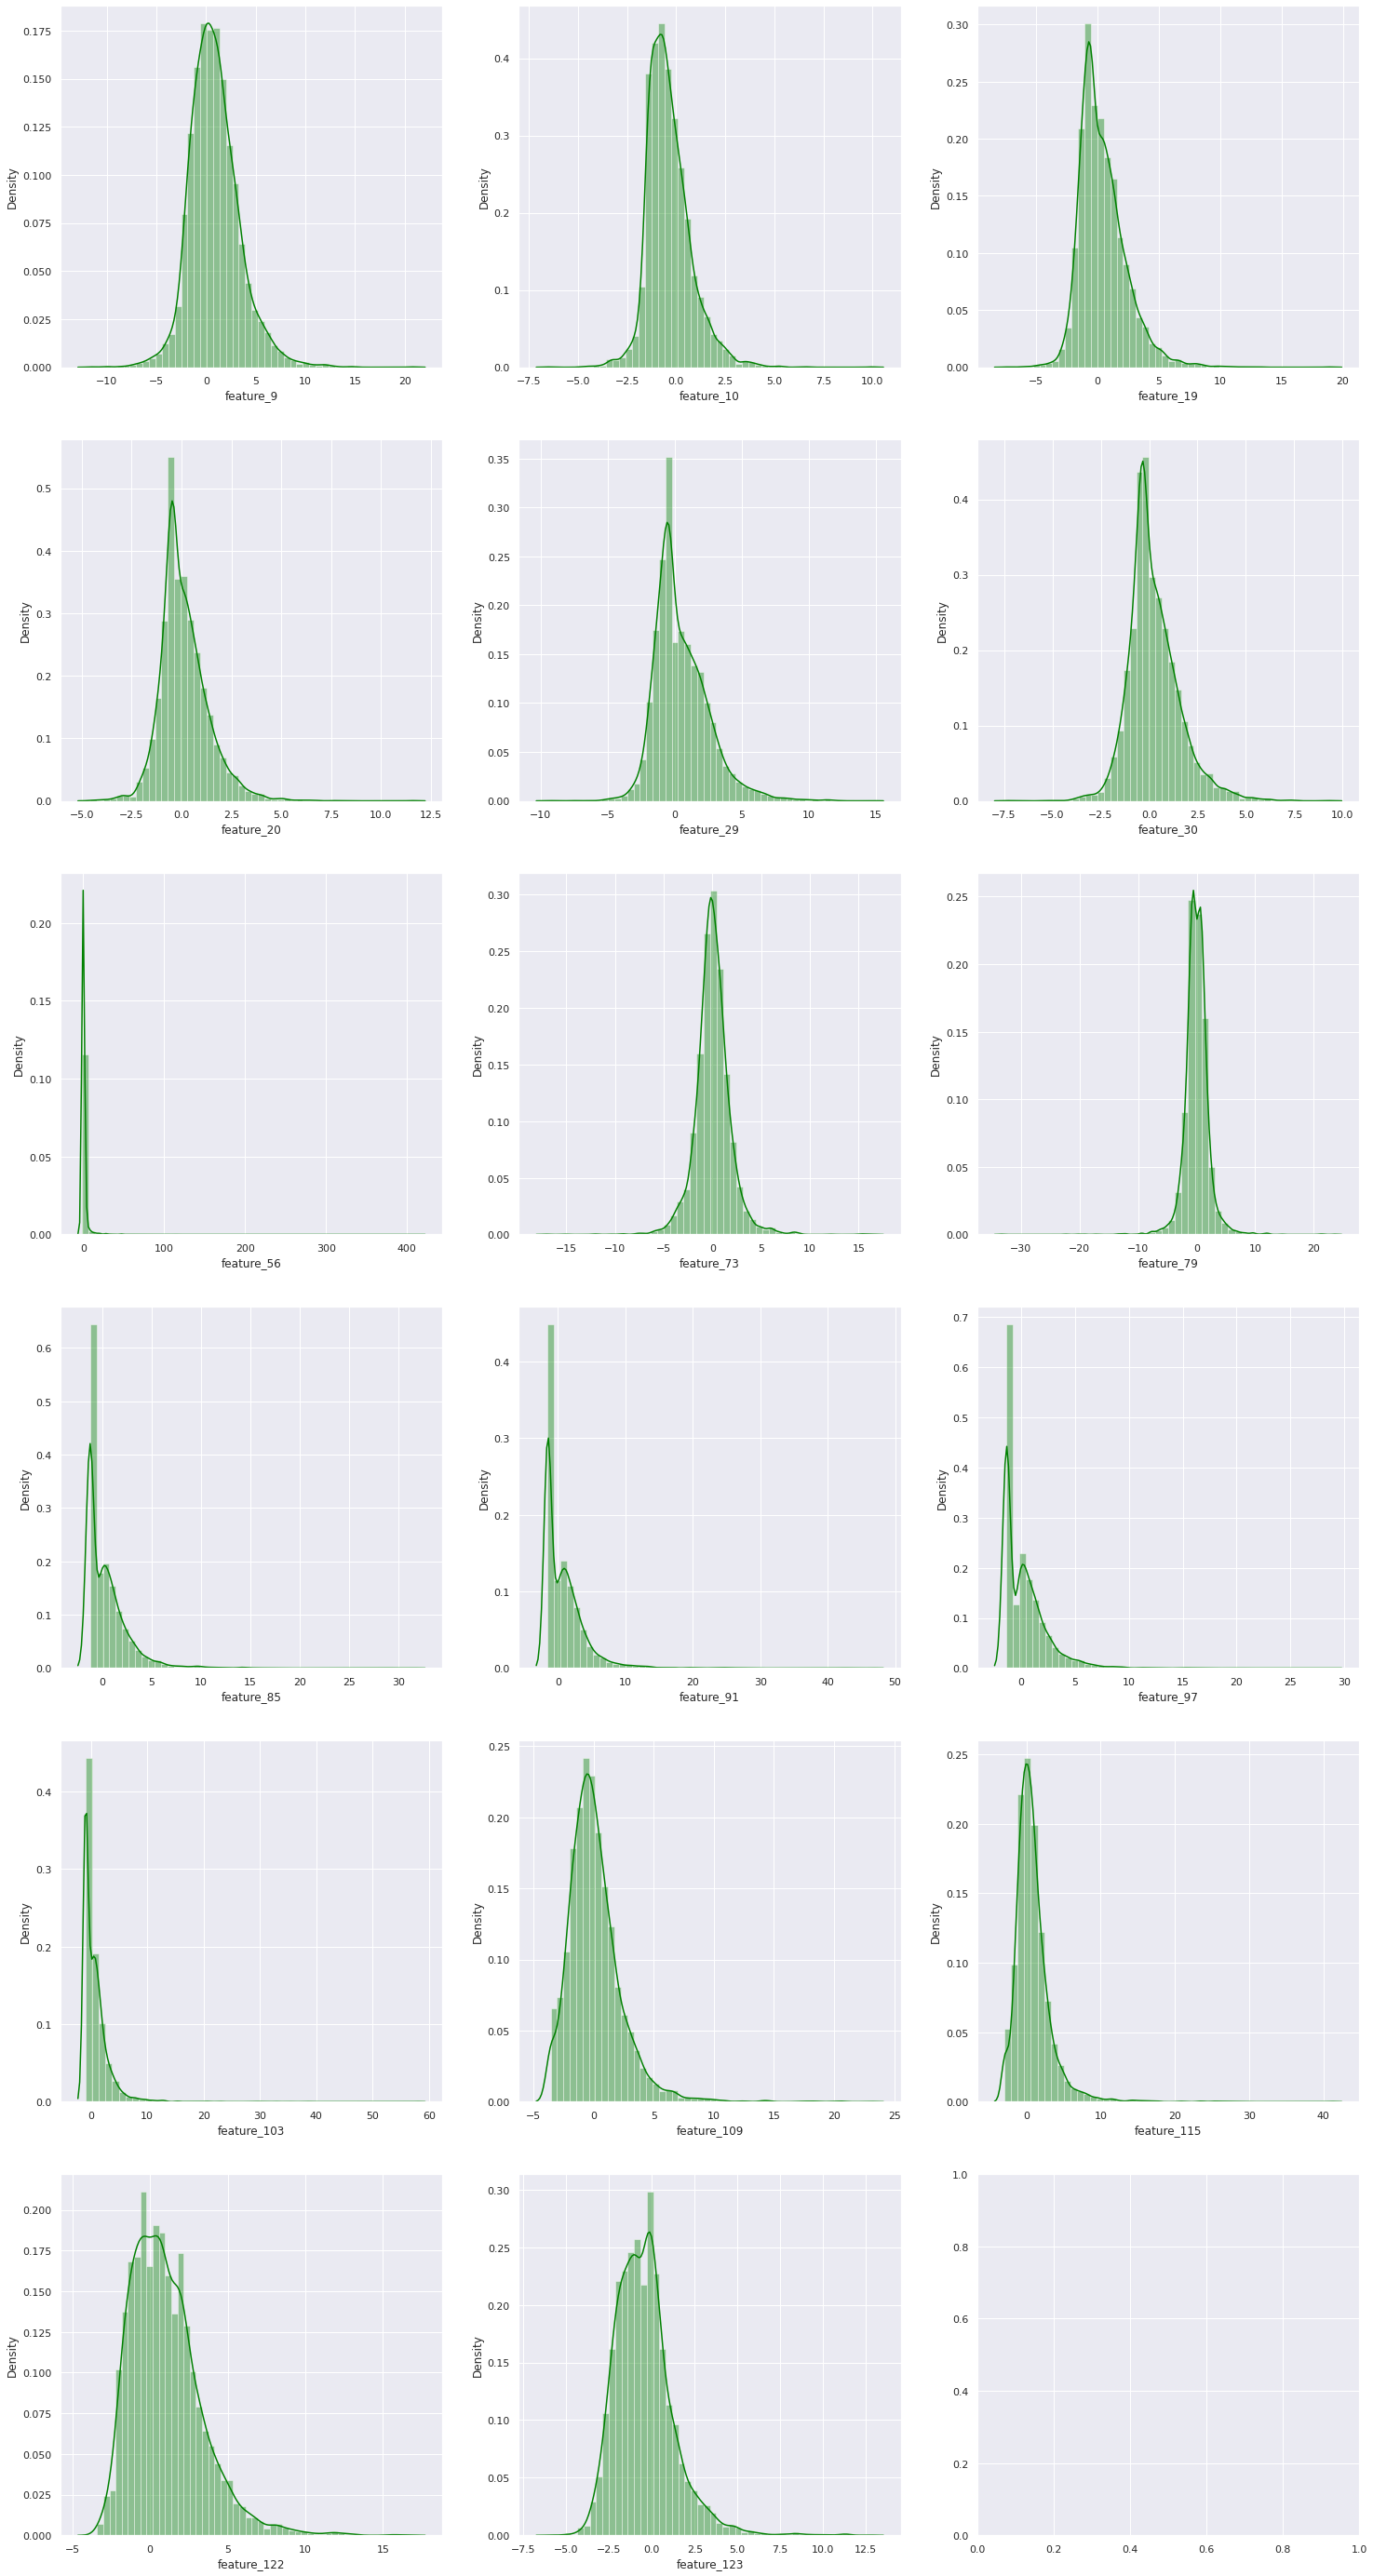

In [ ]:
fig,axs = plt.subplots(6,3,figsize=(25,50))
for i,(col,ax) in enumerate(zip(tag_0_df.columns, axs.flatten())):
    sns.distplot(tag_0_df[col], ax=ax, color='Green')

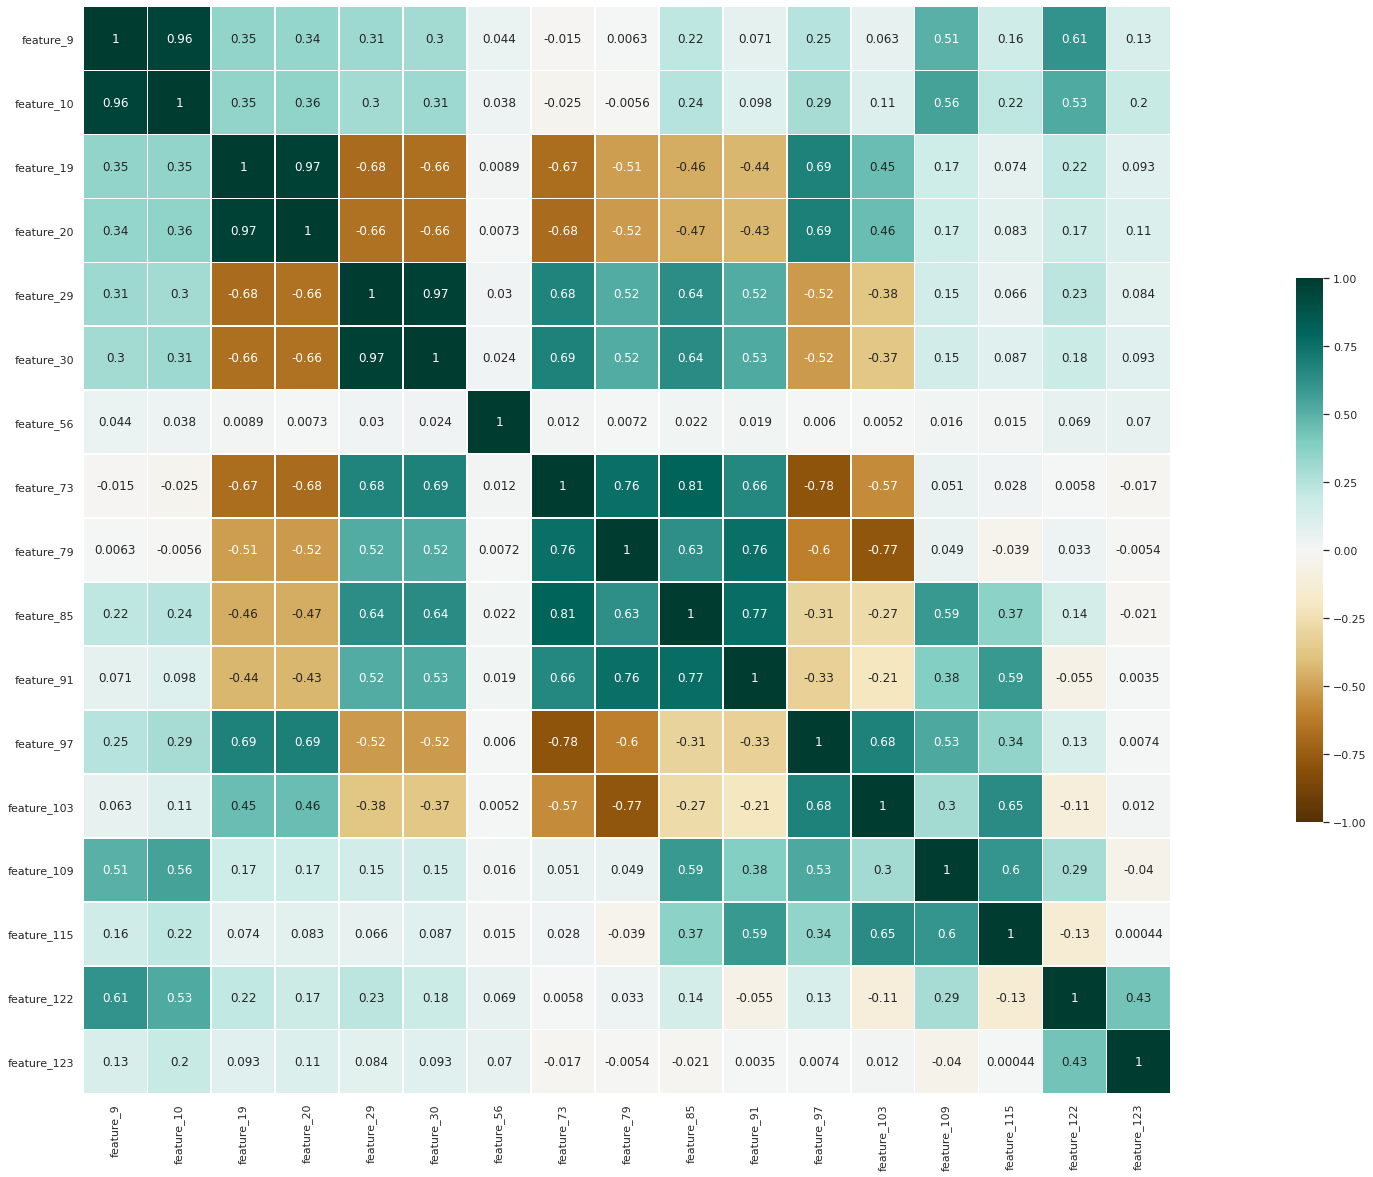

In [ ]:
corr = tag_0_df.corr()
fig,ax = plt.subplots(figsize=(45,20))
_ = sns.heatmap(corr, cmap='BrBG', center=0, vmin=-1, vmax=1,
            annot=True, square=True, linewidths=.5,
            cbar_kws={"shrink": .5})

As we can see that among features of same tag it exist correlation apart from some of features like feature 56 has no correlation with any of member in this group. Some of the features are strongly correlated like feature 9,10 and 19,20. Some of the features are negative correlated for example feature 29 has negative correlation with feature 19 and feature 20. Same case for multiple features in this group/tag.

Another thing to note here is that some features in this tag are part of multiple tags. I will look into these in detail later.


## Insight

- All the featuresthat are in same tag has some correlation with each other.
- But there is one featuers that has no correlation with any other feature in that group and these features are present in first 5 groups that I have explored.
- This correlation pattern exist in group of first featues it means that tow featues(for example 1, 2) will have strong correlation than (3, 4) will have strong correlation.
- By looking at the distribution of features that have no correlation with any other member in group it seems that they have been created from same or eombination of concepts that are being used in weight feature as they both have similar distribution of data.

## Preparing

In [ ]:
train_df = train_df.query('date > 85').reset_index(drop=True)
# limit memory usage
train_df = train_df.astype({c: np.float32
    for c in train_df.select_dtypes(include='float64').columns})
train_df.fillna(train_df.mean(), inplace=True)
train_df = train_df.query('weight > 0').reset_index(drop = True)

train_df['action'] = ((train_df['resp_1'] > 0) &
                      (train_df['resp_2'] > 0) &
                      (train_df['resp_3'] > 0) &
                      (train_df['resp_4'] > 0) &
                      (train_df['resp'] > 0)).astype('int')

features = [c for c in train_df.columns if 'feature' in c]
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']

x_train = train_df[features].values
y_train = np.stack([(train_df[col] > 0).astype('int') 
                        for col in resp_cols]).T
                        
f_mean = np.mean(train_df[features[1:]].values, axis=0)

> Note: Modified code for [`class GroupTimeSeriesSplit(_BaseKFold)`](https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243)

In [ ]:
#collapse-show

from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
#collapse-show
class CVTuner(kt.engine.tuner.Tuner):
    def run_trial(self, trial, X, y, splits, batch_size=32, epochs=1,callbacks=None):
        val_losses = []
        for train_indices, test_indices in splits:
            X_train, X_test = [x[train_indices] for x in X], [x[test_indices] for x in X]
            y_train, y_test = [a[train_indices] for a in y], [a[test_indices] for a in y]
            if len(X_train) < 2:
                X_train = X_train[0]
                X_test = X_test[0]
            if len(y_train) < 2:
                y_train = y_train[0]
                y_test = y_test[0]
            
            model = self.hypermodel.build(trial.hyperparameters)
            hist = model.fit(X_train,y_train,
                      validation_data=(X_test,y_test),
                      epochs=epochs,
                        batch_size=batch_size,
                      callbacks=callbacks)
            
            val_losses.append([hist.history[k][-1] for k in hist.history])
        val_losses = np.asarray(val_losses)
        self.oracle.update_trial(trial.trial_id, {k:np.mean(val_losses[:,i]) for i,k in enumerate(hist.history.keys())})
        self.save_model(trial.trial_id, model)

# Model

As many people have mentioned, finance datasets are usually have low signal-to-noise ratio (SNR). So, here comes an intuitive question. Does Denoising Auto Encoder (DAE) help in reducing noise and cleaning data in finance datasets?

The idea of using an encoder is the denoise the data. After many attempts at using a unsupervised autoencoder, the choice landed on a bottleneck encoder as this will preserve the intra-feature relations.

## Building the autoencoder

The autoencoder should aid in denoising the data based on [this](https://www.semanticscholar.org/paper/Deep-Bottleneck-Classifiers-in-Supervised-Dimension-Parviainen/fb86483f7573f6430fe4597432b0cd3e34b16e43) paper.

In [ ]:
def build_autoencoder(input_dim, output_dim, noise=.05):
    inputs = tf.keras.layers.Input(input_dim)
    encoded = tf.keras.layers.BatchNormalization()(inputs)
    encoded = tf.keras.layers.GaussianNoise(noise)(encoded)
    encoded = tf.keras.layers.Dense(640, activation='relu')(encoded)
    decoded = tf.keras.layers.Dropout(0.2)(encoded)
    decoded = tf.keras.layers.Dense(input_dim, name='decoded')(decoded)
    x = tf.keras.layers.Dense(320, activation='relu')(decoded)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(output_dim, activation='sigmoid',
                              name='label_output')(x)

    encoder = tf.keras.models.Model(inputs=inputs, outputs=encoded)

    autoencoder = tf.keras.models.Model(inputs=inputs, outputs=[decoded,x])
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                        loss={'decoded':'mse',
                              'label_output':'binary_crossentropy'})
    return autoencoder, encoder

## Building the MLP

In [ ]:
def build_model(hp, input_dim, output_dim, encoder):
    inputs = tf.keras.layers.Input(input_dim)
    
    x = encoder(inputs)
    
    x = tf.keras.layers.Concatenate()([x,inputs]) #use both raw and encoded features
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(hp.Float('init_dropout',0.0,0.5))(x)
    
    for i in range(hp.Int('num_layers',1,5)):
        x = tf.keras.layers.Dense(hp.Int('num_units_{i}',128,256))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Lambda(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(hp.Float(f'dropout_{i}',0.0,0.5))(x)

    x = tf.keras.layers.Dense(output_dim,activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=x)

    model.compile(optimizer = tf.keras.optimizers.Adam(
                    hp.Float('lr',0.00001,0.1,default=0.001)),
                  loss = tf.keras.losses.BinaryCrossentropy(
                    label_smoothing = hp.Float('label_smoothing',0.0,0.1)),
                  metrics = [tf.keras.metrics.AUC(name = 'auc')])
    return model

## Defining and training the autoencoder

We add gaussian noise with mean and std from training datea. After training we lock the layersfin the encoder from further training.

In [ ]:
autoencoder, encoder = build_autoencoder(x_train.shape[-1], 
                                         y_train.shape[-1],
                                         noise=0.1)

In [ ]:
#collapse-output
autoencoder.fit(x_train,(x_train, y_train),
                epochs=1000,
                batch_size=4096, 
                validation_split=0.1,
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(
                        'val_loss', patience=10,
                        restore_best_weights=True)])

Epoch 1/1000
346/346 [==============================] - 7s 12ms/step - loss: 2.1184 - decoded_loss: 1.3832 - label_output_loss: 0.7352 - val_loss: 0.8046 - val_decoded_loss: 0.1152 - val_label_output_loss: 0.6894
Epoch 2/1000
346/346 [==============================] - 3s 10ms/step - loss: 1.0088 - decoded_loss: 0.3173 - label_output_loss: 0.6915 - val_loss: 0.7703 - val_decoded_loss: 0.0810 - val_label_output_loss: 0.6893
Epoch 3/1000
346/346 [==============================] - 3s 10ms/step - loss: 0.9952 - decoded_loss: 0.3053 - label_output_loss: 0.6899 - val_loss: 0.7617 - val_decoded_loss: 0.0728 - val_label_output_loss: 0.6890
Epoch 4/1000
346/346 [==============================] - 3s 9ms/step - loss: 0.9690 - decoded_loss: 0.2794 - label_output_loss: 0.6895 - val_loss: 0.7576 - val_decoded_loss: 0.0686 - val_label_output_loss: 0.6890
Epoch 5/1000
346/346 [==============================] - 3s 9ms/step - loss: 0.9750 - decoded_loss: 0.2856 - label_output_loss: 0.6894 - val_loss: 0.7

In [ ]:
encoder.save_weights('encoder.hdf5')

In [ ]:
encoder.load_weights('encoder.hdf5')
encoder.trainable = False

## Running CV

Following [this notebook](https://www.kaggle.com/gogo827jz/jane-street-ffill-xgboost-purgedtimeseriescv) which use 5 `PurgedGroupTimeSeriesSplit` split on the dates in the training data. 

We add the locked encoder as the first layer of the MLP. This seems to help in speeding up the submission rather than first predicting using the encoder then using the MLP. 

We use a Baysian Optimizer to find the optimal HPs for out model. 20 trials take about 2 hours on GPU.


In [ ]:
model_fn = lambda hp: build_model(
    hp, x_train.shape[-1], y_train.shape[-1], encoder)

In [ ]:
tuner = CVTuner(
    hypermodel = model_fn,
    oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective('val_auc', direction='max'),
        num_initial_points=4,
        max_trials=20))

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [ ]:
#collapse-output
gkf = PurgedGroupTimeSeriesSplit(n_splits = 5, group_gap=20)
splits = list(gkf.split(y_train, groups=train_df['date'].values))
tuner.search((x_train,),(y_train,),
             splits=splits,
             batch_size=4096,
             epochs=100,
             callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    'val_auc', mode='max', patience=3)])

In [ ]:
hp  = tuner.get_best_hyperparameters(1)[0]
pd.to_pickle(hp,f'./best_hp_{SEED}.pkl')
for fold, (train_indices, test_indices) in enumerate(splits):
    model = model_fn(hp)
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=4096,callbacks=[EarlyStopping('val_auc',mode='max',patience=10,restore_best_weights=True)])
    model.save_weights(f'./model_{SEED}_{fold}.hdf5')
    model.compile(Adam(hp.get('lr')/100),loss='binary_crossentropy')
    model.fit(X_test,y_test,epochs=3,batch_size=4096)
    model.save_weights(f'./model_{SEED}_{fold}_finetune.hdf5')
tuner.results_summary()